### Multiclass Classification Using QNNClassifier in FastQML

This demonstration highlights the application of a Quantum Neural Network (QNN) Classifier using the FastQML framework, emphasizing the seamless integration and intuitive usability of FastQML for quantum machine learning (QML) model development. By leveraging the unique capabilities of quantum computing, the QNNClassifier is employed to tackle a multiclass classification challenge. The primary goal of this notebook is to illustrate the straightforward process of setting up, training, and evaluating a QNN for a practical classification scenario, showcasing FastQML's effectiveness and user-friendly approach to implementing QML models.

In [1]:
# Project imports
import optax
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from fast_qml.quantum_circuits.feature_maps import AngleEmbedding
from fast_qml.quantum_circuits.variational_forms import EfficientSU2, StronglyEntanglingLayers
from fast_qml.estimators.quantum import QNNClassifier
from fast_qml.core.callbacks import EarlyStopping

# Project constants
QUBITS_N = 4
LEARNING_RATE = 0.1
EPOCHS_NUM = 500
RANDOM_SEED = 42
TEST_SIZE = 0.3

The dataset used in this demonstration is the Iris dataset, a classic dataset in machine learning and statistics. It consists of 150 samples of iris flowers from three different species. Each sample has four features: the length and the width of the sepals and petals.

The preprocessing steps include:
- Normalizing the feature data to ensure effective training of the neural network.
- Splitting the dataset into training, validation, and testing sets for a comprehensive evaluation.

In [2]:
# Load the iris dataset
data = load_iris()
X, y = data.data, data.target

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=TEST_SIZE, shuffle=True, random_state=RANDOM_SEED)

print(X_train.shape, X_test.shape, X_val.shape)

(105, 4) (14, 4) (31, 4)


The setup for the Quantum Neural Network includes:
- Defining the number of qubits, which corresponds to the number of features in the dataset.
- Choosing a feature map to encode classical data into quantum states.
- Selecting an ansatz (variational form) which defines the structure of the quantum circuit used in the neural network.

For the purpose of the demonstration AngleEmbedding feature map will be used with EfficientSU2 variational form.

In [3]:
# AngleEmbedding encodes the number of features equal to number of qubits
feature_map = AngleEmbedding(
    n_qubits=QUBITS_N
)

# EfficientSU2 ansatz
ansatz = EfficientSU2(
    n_qubits=QUBITS_N,
    entanglement='full',
    skip_last_rotations=False,
    reps=1
)

Having all components let's create a QNNClassifier and draw it's circuit.

In [4]:
# Create QNNClassifier model with defined ansatz and feature map
model = QNNClassifier(
    n_qubits=QUBITS_N,
    feature_map=feature_map,
    ansatz=ansatz,
    loss_fn=optax.softmax_cross_entropy_with_integer_labels,
    optimizer_fn=optax.adam,
    data_reuploading=False,
    layers_num=3,
    classes_num=3
)

model.draw_circuit()

0: ─╭AngleEmbedding(M0)──RY(0.07)───RX(-0.01)─╭●─╭●─╭●───────────||──RY(0.00)──RX(-0.13)──RY(0.20)─
1: ─├AngleEmbedding(M0)──RY(-0.02)──RX(0.17)──╰X─│──│──╭●─╭●─────||──RY(0.14)──RX(0.04)───RY(0.04)─
2: ─├AngleEmbedding(M0)──RY(-0.00)──RX(-0.18)────╰X─│──╰X─│──╭●──||──RY(0.07)──RX(-0.05)──RY(-0.05)
3: ─╰AngleEmbedding(M0)──RY(-0.03)──RX(-0.14)───────╰X────╰X─╰X──||──RY(0.11)──RX(-0.02)──RY(0.02)─

───RX(-0.01)─╭●─╭●─╭●───────────||──RY(0.10)───RX(-0.03)──RY(0.03)───RX(0.05)──╭●─╭●─╭●───────────||
───RX(0.05)──╰X─│──│──╭●─╭●─────||──RY(-0.08)──RX(-0.08)──RY(-0.06)──RX(0.24)──╰X─│──│──╭●─╭●─────||
───RX(-0.06)────╰X─│──╰X─│──╭●──||──RY(0.32)───RX(0.10)───RY(-0.03)──RX(-0.30)────╰X─│──╰X─│──╭●──||
───RX(0.09)────────╰X────╰X─╰X──||──RY(0.02)───RX(-0.11)──RY(0.13)───RX(0.14)────────╰X────╰X─╰X──||

───RY(-0.07)──RX(0.07)──┤  
───RY(0.04)───RX(0.15)──┤  
───RY(-0.13)──RX(-0.12)─┤  
───RY(-0.07)──RX(0.02)──┤  
M0 = 
[[-0.90517736  0.92982052  0.50332997  0.22894575]]


Now we can fit the model, with validation and early stopping mechanism.

In [5]:
early_stopping = EarlyStopping(patience=25)

model.fit(
    train_data=X_train,
    train_targets=y_train,
    val_data=X_val,
    val_targets=y_val,
    num_epochs=EPOCHS_NUM,
    learning_rate=LEARNING_RATE,
    batch_size=len(y_train),
    early_stopping=early_stopping
)

Epoch 1/500 - train_loss: 1.06606 - val_loss: 0.98031
Epoch 2/500 - train_loss: 1.02541 - val_loss: 0.94485
Epoch 3/500 - train_loss: 0.98754 - val_loss: 0.92525
Epoch 4/500 - train_loss: 0.95678 - val_loss: 0.90849
Epoch 5/500 - train_loss: 0.92854 - val_loss: 0.86296
Epoch 6/500 - train_loss: 0.89188 - val_loss: 0.78849
Epoch 7/500 - train_loss: 0.85226 - val_loss: 0.74151
Epoch 8/500 - train_loss: 0.81683 - val_loss: 0.72452
Epoch 9/500 - train_loss: 0.78283 - val_loss: 0.72488
Epoch 10/500 - train_loss: 0.76177 - val_loss: 0.70999
Epoch 11/500 - train_loss: 0.74748 - val_loss: 0.68673
Epoch 12/500 - train_loss: 0.73840 - val_loss: 0.67458
Epoch 13/500 - train_loss: 0.73443 - val_loss: 0.67375
Epoch 14/500 - train_loss: 0.72799 - val_loss: 0.67938
Epoch 15/500 - train_loss: 0.72238 - val_loss: 0.67675
Epoch 16/500 - train_loss: 0.71822 - val_loss: 0.65966
Epoch 17/500 - train_loss: 0.71207 - val_loss: 0.63830
Epoch 18/500 - train_loss: 0.70398 - val_loss: 0.62140
Epoch 19/500 - trai

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.67      0.80         6
           2       0.71      1.00      0.83         5

    accuracy                           0.86        14
   macro avg       0.90      0.89      0.88        14
weighted avg       0.90      0.86      0.85        14


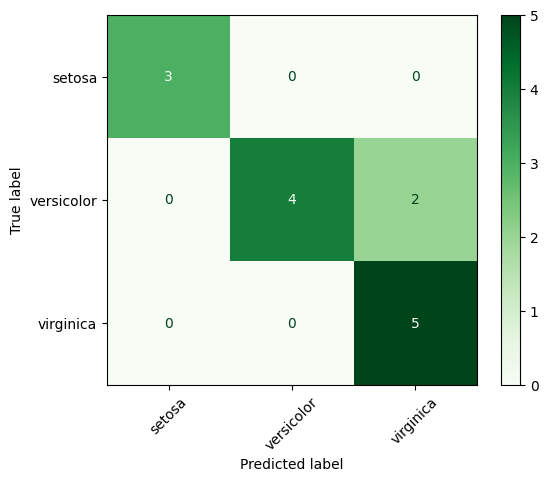

In [6]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['setosa', 'versicolor', 'virginica'])
disp.plot(cmap='Greens', xticks_rotation=45)
plt.show()

We have successfully trained a pretty decent Quantum Neural Network (QNN) using a straightforward and efficient approach. Our next objective is to further enhance the performance and efficiency of our QNN. To achieve this, we will be implementing the data reuploading technique. We will also use [StronglyEntanglingLayers](https://arxiv.org/abs/1804.00633), inspired by the circuit-centric classifier design.

Data reuploading is a powerful strategy that allows for repeated encoding of classical data into quantum states within a single quantum circuit. This technique effectively enhances the capacity of the quantum model to capture complex patterns and relationships in the data, leading to potentially improved performance in tasks like classification and regression.

In [7]:
# AngleEmbedding encodes the number of features equal to number of qubits
feature_map = AngleEmbedding(
    n_qubits=QUBITS_N
)

# StronglyEntanglingLayers ansatz with 3 layers
ansatz = StronglyEntanglingLayers(
    n_qubits=QUBITS_N,
    n_layers=2
)

In [8]:
# Create QNNClassifier model with defined ansatz and feature map
# Use data reuploading technique by setting data_reuploading to True
model = QNNClassifier(
    n_qubits=QUBITS_N,
    feature_map=feature_map,
    ansatz=ansatz,
    loss_fn=optax.softmax_cross_entropy_with_integer_labels,
    optimizer_fn=optax.adam,
    data_reuploading=True,
    layers_num=3,
    classes_num=3
)

In [9]:
model.draw_circuit()

0: ─╭AngleEmbedding(M0)─╭StronglyEntanglingLayers(M1)─╭AngleEmbedding(M0)
1: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─├AngleEmbedding(M0)
2: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─├AngleEmbedding(M0)
3: ─╰AngleEmbedding(M0)─╰StronglyEntanglingLayers(M1)─╰AngleEmbedding(M0)

──╭StronglyEntanglingLayers(M2)─╭AngleEmbedding(M0)─╭StronglyEntanglingLayers(M3)─┤  
──├StronglyEntanglingLayers(M2)─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M3)─┤  
──├StronglyEntanglingLayers(M2)─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M3)─┤  
──╰StronglyEntanglingLayers(M2)─╰AngleEmbedding(M0)─╰StronglyEntanglingLayers(M3)─┤  
M0 = 
[[-0.76072783 -1.14366526  0.49996711  0.8321012 ]]
M1 = 
[[[-0.0342929   0.08387341  0.08490987]
  [ 0.11877021 -0.01836225  0.11913994]
  [ 0.06306056 -0.01886666 -0.04601978]
  [ 0.03084358 -0.02434162  0.20173871]]

 [[ 0.14504669  0.07891046  0.03768606]
  [ 0.01569658 -0.06130155 -0.02825395]
  [ 0.0161345   0.13143318 -0.11183621]
  [ 0.0156313

In [10]:
early_stopping = EarlyStopping(patience=25)

model.fit(
    train_data=X_train,
    train_targets=y_train,
    val_data=X_val,
    val_targets=y_val,
    learning_rate=LEARNING_RATE,
    num_epochs=EPOCHS_NUM,
    batch_size=len(y_train),
    early_stopping=early_stopping
)

Epoch 1/500 - train_loss: 1.10887 - val_loss: 0.93292
Epoch 2/500 - train_loss: 1.00334 - val_loss: 0.88808
Epoch 3/500 - train_loss: 0.97461 - val_loss: 0.84282
Epoch 4/500 - train_loss: 0.93259 - val_loss: 0.83125
Epoch 5/500 - train_loss: 0.90875 - val_loss: 0.79999
Epoch 6/500 - train_loss: 0.87284 - val_loss: 0.75384
Epoch 7/500 - train_loss: 0.82960 - val_loss: 0.72699
Epoch 8/500 - train_loss: 0.80000 - val_loss: 0.70916
Epoch 9/500 - train_loss: 0.77322 - val_loss: 0.69682
Epoch 10/500 - train_loss: 0.75100 - val_loss: 0.69210
Epoch 11/500 - train_loss: 0.74168 - val_loss: 0.68220
Epoch 12/500 - train_loss: 0.73313 - val_loss: 0.66018
Epoch 13/500 - train_loss: 0.71419 - val_loss: 0.64028
Epoch 14/500 - train_loss: 0.69406 - val_loss: 0.63070
Epoch 15/500 - train_loss: 0.67996 - val_loss: 0.62231
Epoch 16/500 - train_loss: 0.66657 - val_loss: 0.60946
Epoch 17/500 - train_loss: 0.65114 - val_loss: 0.59806
Epoch 18/500 - train_loss: 0.63711 - val_loss: 0.59578
Epoch 19/500 - trai

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14


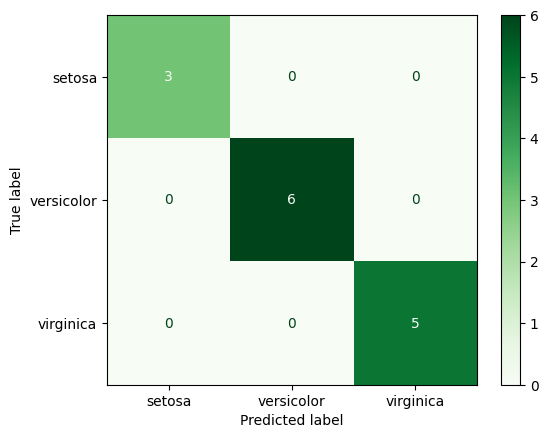

In [11]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['setosa', 'versicolor', 'virginica'])
disp.plot(cmap='Greens')
plt.show()